In [1]:
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.utils import multi_gpu_model, to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
train.isnull().sum()/len(train)*100
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df = train
meanAge = int(df.Age.mean())
df.Age = df.Age.fillna(meanAge)
df = df.drop(['Cabin', 'Embarked', 'Ticket', 'Name', 'PassengerId'], axis=1)
df.Sex = df.Sex.map({'female': 1, 'male': 0})
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


In [4]:
df.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,0.543351,-0.067814,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.131900,-0.334974,0.083081,0.018443,-0.549500
Sex,0.543351,-0.131900,1.000000,-0.082949,0.114631,0.245489,0.182333
Age,-0.067814,-0.334974,-0.082949,1.000000,-0.232978,-0.176486,0.093706
SibSp,-0.035322,0.083081,0.114631,-0.232978,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,0.245489,-0.176486,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.182333,0.093706,0.159651,0.216225,1.000000


In [5]:
Y_train = np.array(df.Survived).reshape((-1, 1))
Y_train[:10]
df = df.drop(['Survived', 'Pclass'], axis=1)

In [6]:
randforestregressor = RandomForestRegressor(max_depth=10, random_state=1, verbose=1)
df = pd.get_dummies(df)
randforestregressor.fit(df, train.Survived)

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1, verbose=1, warm_start=False)

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/
Code for RandomForestRegressor was taken from here as well as ideas for feature selection and dimensionality reduction techniques.

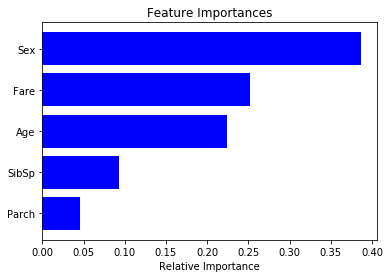

In [7]:
#look at feature importance
features = df.columns
importances = randforestregressor.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
def buildModel():
    # NEED TO EXPERIMENT WITH MODEL ARCHITECTURES
    # FIRST TEST IS NUMBER OF DENSE LAYERS FROM 0 - 5
    num_models = 6
    model = [0] * num_models
    
    for i in range(num_models):
        inputs = Input(shape=(5,))
        
        X = inputs
        
        for j in range(i):
            X = Dense(8, activation='relu', kernel_regularizer='l2')(X)
        
        outputs = Dense(1, activation='sigmoid', kernel_regularizer='l2')(X)
        
        model[i] = multi_gpu_model(Model(inputs=inputs, outputs=outputs), gpus=2) #initialise model with 2 GPUs
        model[i].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = buildModel()
model[0].summary()

In [9]:
X_train = df.to_numpy()

# REDUCE LEARNING RATE ON PLATEAU
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

In [ ]:
# EARLY STOPPING
early_stop = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=11, restore_best_weights=True, verbose=1)

history = [0] * 6
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size=0.1)

for i in range(6):
    history[i] = model[i].fit(x=X_train2, y=Y_train2, batch_size=128, epochs=100, callbacks=[reduce_lr], validation_data=[X_val2, Y_val2], verbose=0)
    print("NN {0:d}: No. dense layers = {1:d}, Train accuracy = {2:.5f}, Validation accuracy = {3:.5f}".format(i+1, i, max(history[i].history['acc']), max(history[i].history['val_acc'])))

Based on above results, 4 is the best number of dense layers. Next is experimenting with number of neurons in each layer.

In [ ]:
def buildModel2():
    # NEED TO EXPERIMENT WITH MODEL ARCHITECTURES
    # SECOND TEST IS NUMBER OF NEURONS IN EACH LAYER FROM 8-128
    num_models = 5
    model = [0] * num_models
    
    for i in range(num_models):
        inputs = Input(shape=(5,))
        
        X = inputs
        
        for j in range(4):
            X = Dense(8*(2**(i+j)), activation='relu', kernel_regularizer='l2')(X)
        
        outputs = Dense(1, activation='sigmoid', kernel_regularizer='l2')(X)
        
        model[i] = multi_gpu_model(Model(inputs=inputs, outputs=outputs), gpus=2) #initialise model with 2 GPUs
        model[i].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = buildModel2()
model[0].summary()

In [ ]:
history = [0] * 5
X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size=0.1)

for i in range(5):
    history[i] = model[i].fit(x=X_train2, y=Y_train2, batch_size=128, epochs=100, callbacks=[reduce_lr], validation_data=[X_val2, Y_val2], verbose=0)
    print("NN {0:d}: No. nodes in layer = {1:d}, Train accuracy = {2:.5f}, Validation accuracy = {3:.5f}".format(i+1, 8*(2**i), max(history[i].history['acc']), max(history[i].history['val_acc'])))

Overall 32 nodes in each layer is the most consistent.

In [10]:
def buildModel3():
    # BUILD 15 MODELS OF ARCHITECTURE INPUT => D32 => D64 => D128 => D256 => OUTPUT
    num_models = 15
    model = [0] * num_models
    
    for i in range(num_models):
        inputs = Input(shape=(5,))
        
        X = inputs
        
        X = Dense(32, activation='relu', kernel_regularizer='l2')(X)
        X = Dense(64, activation='relu', kernel_regularizer='l2')(X)
        X = Dense(128, activation='relu', kernel_regularizer='l2')(X)
        X = Dense(256, activation='relu', kernel_regularizer='l2')(X)
        
        outputs = Dense(1, activation='sigmoid')(X)
        
        model[i] = multi_gpu_model(Model(inputs=inputs, outputs=outputs), gpus=2) #initialise model with 2 GPUs
        model[i].compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [11]:
model = buildModel3()
model[0].summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 5)            0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 5)            0           input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            43905       lambda_1[0][0]                   
                                                                 lambda_2[0][0]                   
__________

In [12]:
history = [0] * 15

for i in range(15):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size=0.1)
    history[i] = model[i].fit(x=X_train2, y=Y_train2, batch_size=128, epochs=100, callbacks=[reduce_lr], validation_data=[X_val2, Y_val2], verbose=0)
    print("NN {0:d}: Train accuracy = {1:.5f}, Validation accuracy = {2:.5f}".format(i+1, max(history[i].history['acc']), max(history[i].history['val_acc'])))

NN 1: Train accuracy = 0.80150, Validation accuracy = 0.85556
NN 2: Train accuracy = 0.80649, Validation accuracy = 0.82222
NN 3: Train accuracy = 0.80899, Validation accuracy = 0.84444
NN 4: Train accuracy = 0.80400, Validation accuracy = 0.81111
NN 5: Train accuracy = 0.79526, Validation accuracy = 0.80000
NN 6: Train accuracy = 0.80524, Validation accuracy = 0.77778
NN 7: Train accuracy = 0.80649, Validation accuracy = 0.81111
NN 8: Train accuracy = 0.81773, Validation accuracy = 0.78889
NN 9: Train accuracy = 0.81773, Validation accuracy = 0.77778
NN 10: Train accuracy = 0.81398, Validation accuracy = 0.82222
NN 11: Train accuracy = 0.80025, Validation accuracy = 0.85556
NN 12: Train accuracy = 0.80150, Validation accuracy = 0.84444
NN 13: Train accuracy = 0.80400, Validation accuracy = 0.84444
NN 14: Train accuracy = 0.80025, Validation accuracy = 0.81111
NN 15: Train accuracy = 0.80025, Validation accuracy = 0.90000


In [24]:
test = pd.read_csv('test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [25]:
def dataPreprocess(df, meanAge):
    preprocessed_df = df
    preprocessed_df.Age = preprocessed_df.Age.fillna(meanAge)
    preprocessed_df = preprocessed_df.drop(['Cabin', 'Embarked', 'Ticket', 'Name', 'PassengerId', 'Pclass'], axis=1)
    preprocessed_df.Sex = preprocessed_df.Sex.map({'female': 1, 'male': 0})
    
    return preprocessed_df

In [26]:
test_df = dataPreprocess(test, meanAge)
X_test = test_df.to_numpy()
print(X_test[:10])

[[ 0.     34.5     0.      0.      7.8292]
 [ 1.     47.      1.      0.      7.    ]
 [ 0.     62.      0.      0.      9.6875]
 [ 0.     27.      0.      0.      8.6625]
 [ 1.     22.      1.      1.     12.2875]
 [ 0.     14.      0.      0.      9.225 ]
 [ 1.     30.      0.      0.      7.6292]
 [ 0.     26.      1.      1.     29.    ]
 [ 1.     18.      0.      0.      7.2292]
 [ 0.     21.      2.      0.     24.15  ]]


In [36]:
#predict
results = np.zeros((X_test.shape[0],1))
for i in range(15):
    results = results + model[i].predict(X_test)
results = pd.Series(np.rint(results/15).astype(int).reshape(X_test.shape[0]), name='Survived')
passengerid = test.PassengerId
submission = pd.concat([passengerid, results], axis=1)
submission.to_csv('ENSEMBLE_DENSE_L2.csv', index=False)